# Reuters Clustering Example

## Load data

In [1]:
# Import libraries

# Main
import sys
sys.path.insert(0,'../')
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

# Transformers
from transformers import AutoTokenizer, TFAutoModel

# Sklearn
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Display
from IPython.display import clear_output

clear_output()

### Covid Data

Twitter and reddit datasets.

In [20]:
from utils import Utils
utils = Utils('../../data/', num_workers=10)

In [22]:
# Define language
lang = 'fr'

print('Starting...')
twitter_data, twitter_dates = utils.data_loader(lang, 'tweets', total_data=115000, max_size = 300, return_dates = True)
reddit_data, reddit_dates = utils.data_loader(lang, 'reddit', total_data=4600, max_size = 300, return_dates = True)

print(f'Loaded {len(twitter_data)} Tweets {len(reddit_data)} Reddit docs')

Starting...
Starting threads to load 115000 documents from tweets in fr
Loaded 115000 files in 14.28 seconds.
Removed 0 files becasuse they were too large
Starting threads to load 4600 documents from reddit in fr
Loaded 4502 files in 0.47 seconds.
Removed 98 files becasuse they were too large
Loaded 115000 Tweets 4502 Reddit docs


### Reuters Dataset

Reuters news dataset (baseline)

In [ ]:
# Download data set
try:
    from nltk.corpus import reuters
except:
    nltk.download('reuters')
    !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora
    from nltk.corpus import reuters

In [ ]:
# Extract dataset
raw_data = []
raw_labels = []
for file in reuters.fileids():
    raw_data.append(reuters.raw(file))
    raw_labels.append(reuters.categories(file))

In [ ]:
# let's consider only 5 categories
our_labels = ['crude', 'coffee', 'grain', 'gold']

# def arrays
data = []
labels = []

# Extract only 5 categories
for i in range(len(raw_labels)):
    if any(item in raw_labels[i] for item in our_labels) and len(raw_data[i].split())<300:
        data.append(raw_data[i])
        labels.append(raw_labels[i])

In [ ]:
# Code labels to just one number
new_labels = []
for label in labels:
    for i, our_lb in enumerate(our_labels):
        if our_lb in label :
            new_labels.append(i)
            break

In [ ]:
print(f'Total documents: {len(new_labels)}')

## Preprocessing

In [57]:
# Stop Words
stop_words = stopwords.words('french')

# Stemmers
stem = SnowballStemmer('french')
#p_stem = PorterStemmer()

# Tokenizers
#tk = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
tk = nltk.RegexpTokenizer(r'\w+')

# Lemmatizer
lemma = nltk.stem.WordNetLemmatizer()

# Preprocess data
corpus = []
for d in reddit_data+twitter_data:
    corpus.append(utils.preprocessing(d, stop_words = stop_words,
                                         stemmer = None,
                                         tokenizer = tk,
                                         lemmatizer = lemma))
print(len(corpus))

119502


## BERT Embedding

In [58]:
# Bert-Large instance (COVID) IF WE HAD TIME
#tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
#model = TFAutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", output_hidden_states=False)

# Bert instance EN (COVID)
#tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-covid19-base-uncased")
#model = TFAutoModel.from_pretrained("vinai/bertweet-covid19-base-uncased", output_hidden_states=False)

# Bert instance FR
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-french-europeana-cased")
model = TFAutoModel.from_pretrained("dbmdz/bert-base-french-europeana-cased", output_hidden_states=True)

# Bert instance ES (BETICO)
#tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
#model = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", output_hidden_states=False)

Some layers from the model checkpoint at dbmdz/bert-base-french-europeana-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-french-europeana-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [59]:
# Test Model for first sentence
inputs = tokenizer(corpus[0], padding='max_length', return_tensors="tf", is_split_into_words=True)
outputs = model(**inputs)

# Just pooler output as embeddings
embedding = outputs['pooler_output'][0].numpy()

In [60]:
# Array to save embeddings
reu_embeddings = []

failed_doc_ids = []

for i, doc in enumerate(tqdm(corpus)):
    try:
        # Run Bert for each document
        inputs = tokenizer(doc, return_tensors="tf", is_split_into_words=True)
        outputs = model(**inputs)

        # CLS Token Output
        embedding = outputs['pooler_output'][0].numpy()
        
        # Append representation
        reu_embeddings.append(embedding)
        
    except:
        failed_doc_ids.append(i)

# Remove doc
for doc_id in failed_doc_ids:
    corpus.pop(doc_id)
    reddit_dates.pop(doc_id)

100%|██████████| 119502/119502 [2:31:01<00:00, 13.19it/s] 


## Autoencoder

In [61]:
# Declare autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   

        self.encoder = tf.keras.models.Sequential()
        self.encoder.add(tf.keras.Input(shape=(768,)))
        #self.encoder.add(layers.Dense(300, activation='relu'))
        self.encoder.add(layers.Dense(latent_dim, activation='linear'))

        self.decoder = tf.keras.models.Sequential()
        #self.decoder.add(layers.Dense(300, activation='relu'))
        self.decoder.add(tf.keras.layers.Dense(768, activation='linear'))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [62]:
# Compile autoencoder
latent_dim = 32
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train
autoencoder.fit(np.asarray(reu_embeddings), np.asarray(reu_embeddings), epochs=15, shuffle=True)

Epoch 1/15
3735/3735 [==============================] - 6s 1ms/step - loss: 0.0142
Epoch 2/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0050
Epoch 3/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 4/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 5/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 6/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 7/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 8/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 9/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0049
Epoch 10/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0048
Epoch 11/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0048
Epoch 12/15
3735/3735 [==============================] - 4s 1ms/step - loss: 0.0048
E

In [63]:
encoded_reu = autoencoder.encoder(np.asarray(reu_embeddings)).numpy()

## Clustering

In [141]:
# K MEANS CLUSTERING
N = 3
k_means = KMeans(N, max_iter = 1000)
clusters_kmeans = k_means.fit_predict(encoded_reu)

In [142]:
# Principal component analysis for dim reduction (optional)
pca = PCA(n_components=2)
X = pca.fit_transform(encoded_reu)

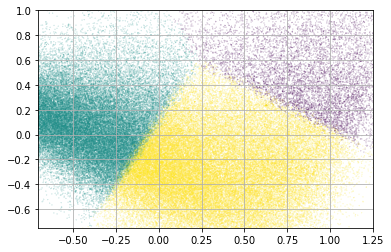

In [143]:
plt.scatter(X[:,0],X[:,1], s=0.01, c=clusters_kmeans)
plt.ylim([-0.75, 1])
plt.xlim([-0.7, 1.25])
plt.grid(True)
plt.savefig(os.path.join(path_to_save, 'PCA_{}.png'.format(N)))
plt.show()

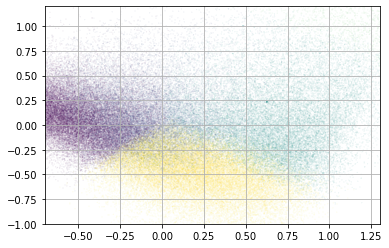

In [76]:
path_to_save = '../../results/TopicDetection/fr/'
plt.scatter(X[:,0],X[:,1], s=0.001, c=clusters_kmeans)
plt.ylim([-1, 1.2])
plt.xlim([-0.7, 1.3])
plt.grid(True)
plt.savefig(os.path.join(path_to_save, 'PCA_{}.png'.format(N)))
plt.show()

In [ ]:
# AGGLOMERATIVE CLUSTERING
agg_clustering = AgglomerativeClustering(n_clusters=4)#, linkage='average', affinity='cosine')
clusters_agg = agg_clustering.fit_predict(encoded_reu)

In [ ]:
# SPECTRAL CLUSTERING
spectral_clustering = SpectralClustering(n_clusters=5, assign_labels='discretize')
clusters_spec = spectral_clustering.fit_predict(encoded_reu)

## Results: KeyWords

Just for K-Means :/

In [69]:
from scipy.spatial import distance

def get_relevant_docs_from_clusters(clustering, embeddings, n_relevant_docs=5):
  
    # Init relevant docs list
    relevant_docs_id = []

    # Get cluster and centers
    centers = clustering.cluster_centers_
    clusters = clustering.labels_

    emb_distances = []

    # Loop around doc embeddings
    for i, emb in enumerate(embeddings):
        # Compute distance between embedding and cluster center
        emb_distances.append(distance.pdist([emb, centers[clusters[i]]]).item(0))

    # Sort distances
    sorted_index = np.argsort(emb_distances)
    emb_distances = np.array(emb_distances)[sorted_index[::-1]]
    clusters = np.array(clusters)[sorted_index[::-1]]

    # Select n relevant docs for each cluster
    for i in range(clustering.n_clusters):
        relevant_docs_cluster = []

        for j, dist in enumerate(emb_distances):
            #print(dist)
            if i == clusters[j]:
                relevant_docs_cluster.append(sorted_index[j])

            if len(relevant_docs_cluster) > n_relevant_docs:
                break

        relevant_docs_id.append(relevant_docs_cluster)

    return relevant_docs_id

In [70]:
def print_relevant_keys_from_docs(docs_id, min_words=4, ignore_words=['covid', 'covid19', 'coronavirus']):
    
    key_words_list = []
    
    # Loop around docs
    for i, docs in enumerate(docs_id):

        # Init tokens array
        tokens = []
        for doc_id in docs:
            # split() returns list of all the words in the string
            tokens = tokens + corpus[doc_id]

        # Pass the list to instance of Counter class.
        key_words = Counter(tokens)
        keys = list(key_words.keys())
        
        # Remove non relevant key_words
        for k in keys:
            if (key_words[k] < min_words) or (k in ignore_words):
                del key_words[k]
        
        key_words_list.append(key_words)
        print(f'Cluster {i}: {key_words}')
        print('')
        
    return key_words_list
    

In [179]:
from collections import Counter

docs_id = get_relevant_docs_from_clusters(k_means, encoded_reu, n_relevant_docs=250)

# Lista de palabras a ignorar
ignore_words_fr = ['covid', 'covid19', 'coronavirus', 'sans', 'a', 'quand', 'non', 'quoi', 'ça', 'va', 'rien', 'cest', 'plus', 'tout', "tous", 'bien', 'via', "faire", "fait", "encore", "vraiment"]
ignore_words_es = ['covid', 'covid19', 'coronavirus', 'gente', 'si', 'personas', 'aún', 'mas', 'bien', 'via', 'q', 'd', 'casos']

key_words_list = print_relevant_keys_from_docs(docs_id, min_words=4, ignore_words=ignore_words_fr)


Cluster 0: Counter({'si': 10, 'bon': 9, 'confinement': 8, 'faut': 7, 'vaccin': 7, 'fin': 7, 'déconfinement': 6, 'peut': 6, 'nouvelle': 6, 'comme': 6, 'là': 6, 'point': 6, 'après': 6, 'monde': 6, 'gens': 5, 'aussi': 5, 'français': 5, 'mai': 5, 'être': 5, 'juste': 5, 'pourquoi': 5, 'france': 5, 'mal': 5, 'pandémie': 5, 'fois': 5, 'allez': 5, 'oui': 4, 'tiens': 4, 'peuton': 4, 'quon': 4, 'lefigaro': 4, 'mdr': 4, 'moment': 4, 'con': 4, 'veux': 4, 'vaccins': 4, 'comment': 4, 'contre': 4, 'temps': 4, 'savoir': 4, 'vais': 4, 'crise': 4, 'couvrefeu': 4, 'face': 4, '19': 4, 'toujours': 4, 'hi': 4, 'bonne': 4, 'pass': 4, 'ni': 4, 'trop': 4})

Cluster 1: Counter({'vaccin': 10, 'faut': 9, 'si': 8, 'comme': 7, 'pays': 7, 'comment': 6, 'youtube': 6, 'déconfinement': 6, 'dit': 6, 'cette': 6, 'alors': 5, 'peu': 5, 'lemondefr': 5, 'être': 5, 'avoir': 5, 'monde': 5, 'cas': 5, 'vaccination': 4, 'là': 4, 'aussi': 4, 'masque': 4, 'obligatoire': 4, 'pandémie': 4, 'vaccins': 4, 'manipulations': 4, 'incroyabl

### WordCount Plots

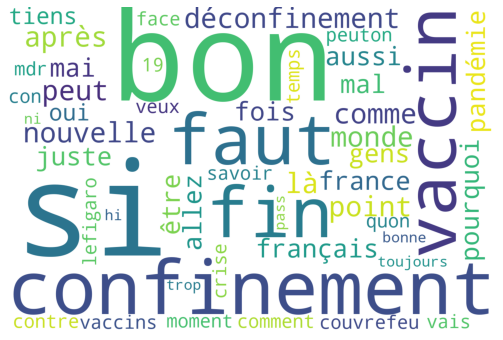

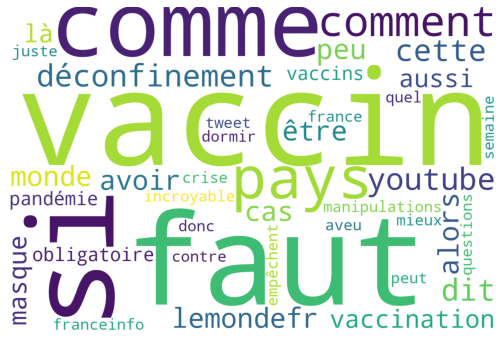

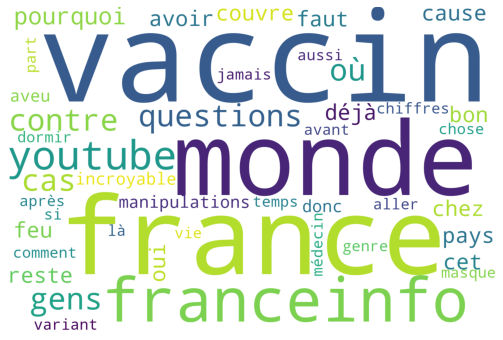

In [180]:
from wordcloud import WordCloud

for i, key_words in enumerate(key_words_list):
    
    wordcloud = WordCloud(background_color='white',
                          width=1500,
                          height=1000
                          ).generate_from_frequencies(key_words)

    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis('off')
#     plt.title(f'Cluster N° {i}', fontsize = 25)
    plt.savefig(os.path.join(path_to_save, 'cluster' + str(N) + '_' + str(i) + '.png'))
    plt.show()

### Time Analysis

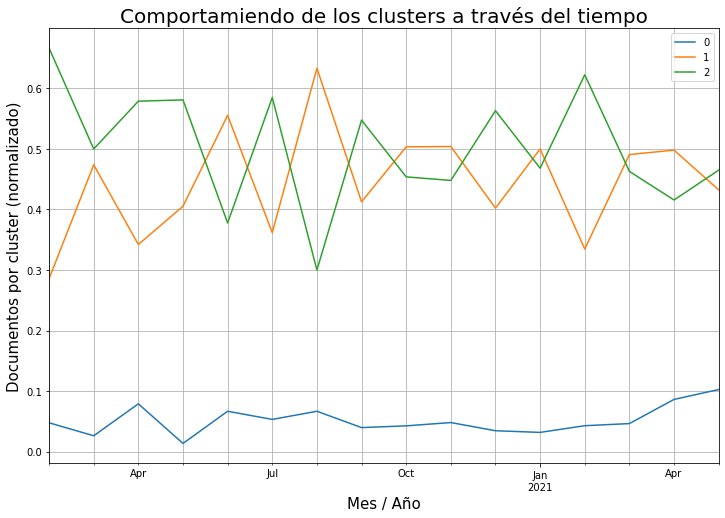

In [181]:
# Init clusters dic
clusters_data = np.zeros((len(corpus), k_means.n_clusters))

# Count by clusters
for i, lb in enumerate(k_means.labels_):
    clusters_data[i,lb] = 1 

# Group by month_year
clusters_df = pd.DataFrame(data = clusters_data)
clusters_df['date'] = reddit_dates + twitter_dates
clusters_df['month_year'] = clusters_df['date'].dt.to_period('M')

# Plot
df = clusters_df.groupby('month_year').sum().copy()
df = df.div(df.sum(axis=1),axis=0)
df.plot(figsize=(12,8))
plt.grid(which='both')
plt.title('Comportamiendo de los clusters a través del tiempo', fontsize=20)
plt.ylabel('Documentos por cluster (normalizado)', fontsize=15)
plt.xlabel('Mes / Año', fontsize=15)
plt.savefig(os.path.join(path_to_save, 'cluster_over_time_{}.png'.format(N)))
plt.show()


### Confusion Matrix

Just for Reuters dataset baseline comparison

In [182]:
import seaborn as sn

# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_kmeans)

# Plot
df_cm = pd.DataFrame(matrix,['Economy', 'Vaxxed', 'Vaccination', 'Mind Health'], range(4))
plt.figure(figsize=(10,7))
plt.title('K MEANS')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [0, 119502]

In [46]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_agg)

# Plot
df_cm = pd.DataFrame(matrix,['crude', 'coffe', 'grain', 'gold'], range(4))
plt.figure(figsize=(10,7))
plt.title('Agglomerative Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

NameError: name 'new_labels' is not defined

In [49]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_spec)

# Plot
df_cm = pd.DataFrame(matrix, ['crude', 'coffe', 'grain', 'gold'], range(4))
plt.figure(figsize=(10,7))
plt.title('Spectral Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

NameError: name 'clusters_spec' is not defined

In [50]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_dbscan)

n_clusters = len(np.unique(clusters_dbscan))

# Plot
df_cm = pd.DataFrame(matrix)#, ['crude', 'jobs','grain', 'gold', 'coffee'], range(5))
plt.figure(figsize=(10,7))
plt.title('DBSCAN Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

NameError: name 'clusters_dbscan' is not defined